<a href="https://colab.research.google.com/github/Atlassian-phoenix/ciphers/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [111]:
# List of your CSV files
files = {
    'mustard': '/content/merged_mustard_reservoir.csv',
    'rabi_rice': '/content/merged_rabi_rice_reservoir.csv',
    'potato': '/content/merged_potato_reservoir.csv',
    'gram': '/content/merged_gram_reservoir.csv',
    'massor': '/content/merged_massor_reservoir.csv',
    'wheat': '/content/merged_wheat_reservoir.csv'
}


In [112]:
# Function to process dataset and train Random Forest model
def process_crop(file_path, crop_name):
    print(f"\nProcessing {crop_name.capitalize()}")


In [113]:
# Load data
df = pd.read_csv('/content/merged_mustard_reservoir.csv')


In [114]:
# Drop rows with missing important features
df = df.dropna(subset=['apy_item_interval_start', 'state_temperature_max_val','state_temperature_min_val', 'state_rainfall_val', 'yield'])
features_base=['apy_item_interval_start', 'state_temperature_max_val','state_temperature_min_val', 'state_rainfall_val']
target='yield'
df_clean=df.dropna(subset=features_base+[target,'state_name'])
df_clean.sort_values(by=['apy_item_interval_start', 'state_name'], inplace=True)
df_clean['lag1']=df_clean.groupby('state_name')['yield'].shift(1)
df_clean['rolling_mean_7']=df_clean.groupby('state_name')['yield'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_final=df_clean.dropna(subset=['lag1','rolling_mean_7'])
features=features_base+['month','day','lag1','rolling_mean_7']
min_records_threshold=50


In [115]:
# Group by year and calculate average
yearly_avg = df.groupby('apy_item_interval_start').agg({
        'state_temperature_max_val': 'mean',
        'state_temperature_min_val': 'mean',
        'state_rainfall_val': 'mean',
        'yield': 'mean'
    }).reset_index()


In [116]:
# Features and target
X = yearly_avg[['apy_item_interval_start', 'state_temperature_max_val','state_temperature_min_val', 'state_rainfall_val']]
y = yearly_avg['yield']


In [117]:
#filter states with enough data
eligible_states= df_final['state_name'].value_counts()
eligible_states=eligible_states[eligible_states>=100]
eligible_states


,count
state_name,
Chhattisgarh,8400
Gujarat,8400
Uttar Pradesh,8400
Uttarakhand,8400
West Bengal,8400
Rajasthan,8400
Madhya Pradesh,8035
Andhra Pradesh,8035
Jharkhand,7669


In [118]:
state_rmse={}
yield_comparison={}

In [119]:
for state in eligible_states:
  state_data=df_final[df_final['state_name']==state]
  train_data=state_data[state_data['apy_item_interval_start']<2022]
  test_data=state_data[state_data['apy_item_interval_start']>=2022]

In [120]:
# Train/test split (use last 3 years as test for forecasting)
train_size = len(X) - 3
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [121]:
# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train , y_train)

RandomForestRegressor(random_state=42)

In [122]:
# Predict
y_pred = model.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
state_rmse[state]=rmse
print(rmse)
print("\nstatewise RMSE:")
for state,rmse in state_rmse.items():
  print(f"{state}:{rmse}")

0.14432804921406958

statewise RMSE:
1460:0.14432804921406958


In [123]:
comparison_df=test_data[['apy_item_interval_start','yield']].copy()
comparison_df['actual_yield']=y_test.values
comparison_df['predicted_yield']=y_pred
comparison_df=comparison_df.groupby('apy_item_interval_start').agg({'actual_yield':'mean','predicted_yield':'mean'}).reset_index()
yield_comparison[state]=comparison_df

In [124]:
print("\npredicted vs actual yield:")
for state in sorted(yield_comparison.keys()):
  print(f"\n{state}:")
  print(yield_comparison[state].to_string(index=False))


predicted vs actual yield:

1460:
Empty DataFrame
Columns: [apy_item_interval_start, actual_yield, predicted_yield]
Index: []


In [125]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

MSE: 0.02
R2 Score: -57.06


In [126]:
# Combine predictions for display
results = X_test.copy()
results['Actual_Yield'] = y_test.values
results['Predicted_Yield'] = y_pred
print(results)


    apy_item_interval_start  state_temperature_max_val  \
20                     2020                  33.566541   
21                     2021                  33.740981   
22                     2022                  34.104027   

    state_temperature_min_val  state_rainfall_val  Actual_Yield  \
20                  17.174872            3.358940      1.120859   
21                  17.408293            3.557523      1.074903   
22                  17.528079            3.189934      1.103400   

    Predicted_Yield  
20         0.955183  
21         0.948795  
22         0.965052  


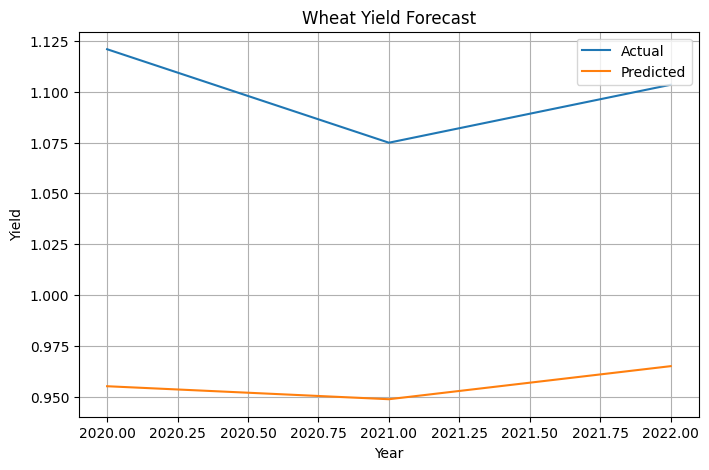

In [127]:
# Plot predictions
plt.figure(figsize=(8, 5))
plt.plot(results['apy_item_interval_start'], results['Actual_Yield'], label='Actual')
plt.plot(results['apy_item_interval_start'], results['Predicted_Yield'], label='Predicted')
plt.title(f"{crop_name.capitalize()} Yield Forecast")
plt.xlabel('Year')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()


In [128]:
# Run the model for each crop
for crop_name, file_path in files.items():
    process_crop(file_path, crop_name)


Processing Mustard

Processing Rabi_rice

Processing Potato

Processing Gram

Processing Massor

Processing Wheat
